In [189]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf
R = 0.1
L= 1
t_last=1

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')  # Replace with your file path

# Sample n points randomly from the DataFrame
n = 100  # Specify how many points you want to sample
sampled_data = df.sample(n=n)

# Split the data into training (60%) and testing (40%)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)

# Training data
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training

# Testing data
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for testing

print(x_train)
print(y_train)
print(sigma_train)
Com=np.stack((x_train,y_train))
com=Com.T
print(com)


[[0.014598  ]
 [0.        ]
 [0.01864032]
 [0.01146986]
 [0.00380756]
 [0.00172085]
 [0.0021211 ]
 [0.05097884]
 [0.00249396]
 [0.01042714]
 [0.00834171]
 [0.04592595]
 [0.01661916]
 [0.03177784]
 [0.02167205]
 [0.0036358 ]
 [0.03885189]
 [0.00481181]
 [0.03278842]
 [0.00399683]
 [0.03177784]
 [0.014598  ]
 [0.04693653]
 [0.00332079]
 [0.04491537]
 [0.00074525]
 [0.03582016]
 [0.04289421]
 [0.0022119 ]
 [0.04390479]
 [0.04693653]
 [0.00169047]
 [0.053     ]
 [0.00398991]
 [0.0061713 ]
 [0.03278842]
 [0.01268713]
 [0.00425526]
 [0.00389416]
 [0.00428838]
 [0.04592595]
 [0.00432255]
 [0.03480958]
 [0.01661916]
 [0.02066147]
 [0.01661916]
 [0.00600971]
 [0.00521357]
 [0.0034389 ]
 [0.00625629]
 [0.00308684]
 [0.0196509 ]
 [0.03076726]
 [0.00064926]
 [0.03278842]
 [0.02369321]
 [0.00153962]
 [0.00394447]
 [0.00257115]
 [0.01864032]]
[[0.02708035]
 [0.01909983]
 [0.02408765]
 [0.02807791]
 [0.00187137]
 [0.01255209]
 [0.00547916]
 [0.008064  ]
 [0.00312733]
 [0.02109496]
 [0.02009739]
 [0.0

In [191]:
data_x=np.column_stack((x_train,y_train))
data_x=data_x
print(data_x.shape)
data_sigma=np.array(sigma_train)
test_x=np.column_stack((x_test,y_test))
test_x=test_x
print(test_x.shape)
test_sigma=np.array(sigma_test)

from sklearn.preprocessing import StandardScaler

# Apply StandardScaler to the training and testing data
scaler_x = StandardScaler()
scaler_s = StandardScaler()

data_x = scaler_x.fit_transform(data_x)
data_sigma=scaler_s.fit_transform(data_sigma)
test_x = scaler_x.transform(test_x)
test_sigma=scaler_s.transform(test_sigma)

print(data_x)
print(data_sigma)
data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)

(60, 2)
(40, 2)
[[-0.1867821   0.56486243]
 [-1.08157929  0.09751679]
 [ 0.06099515  0.38960784]
 [-0.37852437  0.62328065]
 [-0.84819144 -0.91139529]
 [-0.97609843 -0.28592368]
 [-0.95156439 -0.70012005]
 [ 2.04321354 -0.54874988]
 [-0.92870988 -0.83784539]
 [-0.44243846  0.21435314]
 [-0.57026658  0.15593502]
 [ 1.73349172  2.14215393]
 [-0.06289351  1.32429912]
 [ 0.86627147 -0.0777378 ]
 [ 0.24682808 -1.02098407]
 [-0.85871953 -0.85181461]
 [ 1.2998816   1.26588088]
 [-0.78663505 -0.93045557]
 [ 0.92821575  0.09751679]
 [-0.83659024 -0.62520276]
 [ 0.86627147 -0.31263279]
 [-0.1867821  -0.43069131]
 [ 1.79543623  1.85006299]
 [-0.87802853 -0.86392225]
 [ 1.67154745  2.20057217]
 [-1.03589884 -0.6720484 ]
 [ 1.11404856 -0.78486697]
 [ 1.54765892 -0.48972059]
 [-0.94599866 -0.82581336]
 [ 1.60960319  0.15593502]
 [ 1.79543623 -0.84389625]
 [-0.97796026 -0.80868768]
 [ 2.16710208  1.14904442]
 [-0.83701447 -0.80813111]
 [-0.70330416 -0.96240544]
 [ 0.92821575 -0.31263279]
 [-0.3039106

Compiling model...
Building feed-forward neural network...
'build' took 0.070006 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.542919 s

Training model...

Step      Train loss    Test loss     Test metric
0         [9.70e-01]    [9.64e-01]    []  
1000      [5.00e-01]    [4.38e-01]    []  
2000      [9.92e-02]    [4.11e-01]    []  
3000      [8.56e-02]    [4.46e-01]    []  
4000      [8.15e-02]    [4.28e-01]    []  
5000      [7.63e-02]    [4.04e-01]    []  
6000      [6.19e-02]    [3.36e-01]    []  
7000      [2.28e-02]    [1.10e-01]    []  
8000      [5.22e-03]    [1.75e-02]    []  
9000      [9.50e-04]    [2.08e-02]    []  
10000     [3.53e-04]    [1.52e-02]    []  
11000     [1.16e-04]    [1.04e-02]    []  
12000     [4.49e-05]    [7.85e-03]    []  
13000     [2.52e-05]    [6.36e-03]    []  
14000     [1.86e-05]    [5.46e-03]    []  
15000     [1.53e-05]    [4.94e-03]    []  
16000     [1.31e-05]    [4.59e-03]    []  
17000     [1.26e-05]    [4.38e-03]    []  
18000     [9.87e-06]    [4.12e-03]    []  
19000     [8.89e-06]    [3.98e-03]    []  
20000     [7.48e-06]    [3.80e-03]    []  
2

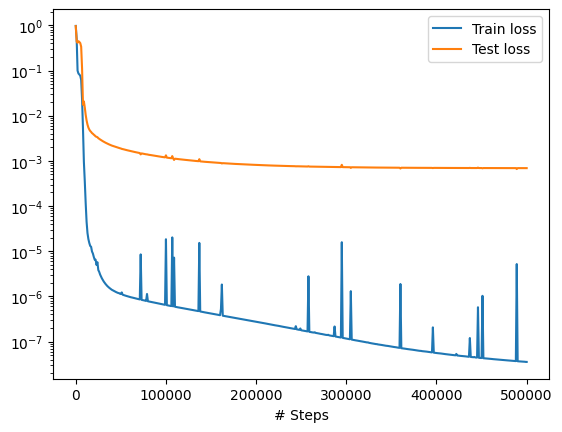

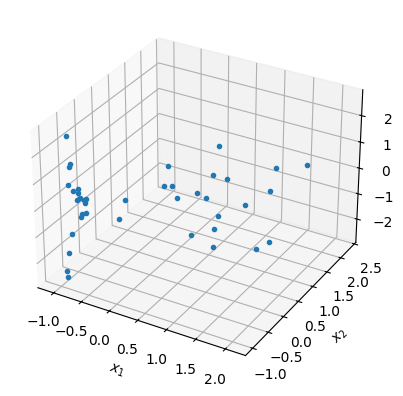

In [192]:


# Define the network for σ
layer_size = [2] + [50] * 7 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "tanh"
initializer = "Glorot uniform"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)

# Define the model
model_sigma = dde.Model(data, net_sigma)

# Compile the model with data
model_sigma.compile("adam", lr=1e-5)

# Train the model
losshistory, train_state = model_sigma.train(epochs=500000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [231]:
Vdata=np.array([[0.008341715,0.030073043]])
Vdata=scaler_x.transform(Vdata)
verify=model_sigma.predict(Vdata)
# Convert predictions back to original scale
predictions_original_scale = scaler_s.inverse_transform(verify)

# Print the predictions in the original scale
print(predictions_original_scale)


[[42621804.]]


In [229]:

X=df.iloc[:,1]
print(X)
X=np.array(X.tolist()).reshape(-1,1)

Y=df.iloc[:,2]
Y=np.array(Y.tolist()).reshape(-1,1)
print(Y)
Cor=np.column_stack([X,Y])
print(Cor)
Cor=scaler_x.transform(Cor)

0       0.014598
1       0.014598
2       0.014598
3       0.014598
4       0.014598
          ...   
3996    0.001037
3997    0.001158
3998    0.001352
3999    0.001268
4000    0.002116
Name: x, Length: 4001, dtype: float64
[[0.014112  ]
 [0.01610713]
 [0.01810226]
 ...
 [0.0049515 ]
 [0.00508507]
 [0.00575253]]
[[0.014598   0.014112  ]
 [0.014598   0.01610713]
 [0.014598   0.01810226]
 ...
 [0.0013522  0.0049515 ]
 [0.00126786 0.00508507]
 [0.00211575 0.00575253]]


0       43584350.60
1       43195861.80
2       42957984.90
3       42829105.40
4       42774711.60
           ...     
3996    -5592885.97
3997    -4353672.03
3998    -2742764.47
3999    -1867401.72
4000    14884028.40
Name: sigma, Length: 4001, dtype: float64
First few actual values: [[-0.10277595]
 [-0.11866376]
 [-0.12839208]
 [-0.13366279]
 [-0.1358873 ]]
First few predicted values: [[-0.06332503]
 [-0.12337264]
 [-0.14373742]
 [-0.14123915]
 [-0.13696317]]
Mean Absolute Percentage Error: 19.81%
R² Score: 1.00


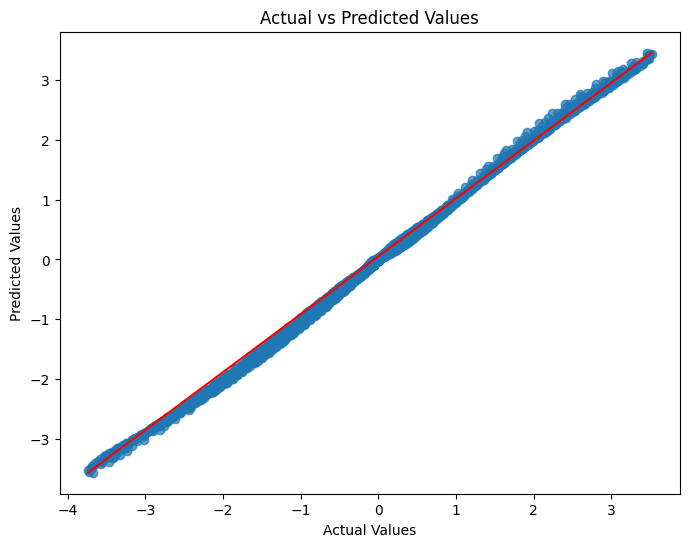

In [230]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Assuming `model_sigma` is your trained model
# `X_test` is your test input data and `y_test` is the actual test output data

# Get predictions on test data
S_p = model_sigma.predict(Cor)
S_t=df.iloc[:,3]
print(S_t)
S_t=np.array(S_t.tolist()).reshape(-1,1)
S_t=scaler_s.transform(S_t)
print("First few actual values:", S_t[:5])
print("First few predicted values:", S_p[:5])
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(S_t, S_p) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Calculate R² Score
r2 = r2_score(S_t, S_p)
print(f"R² Score: {r2:.2f}")

# Plot the actual vs predicted values for test data
plt.figure(figsize=(8, 6))
plt.scatter(S_t, S_p, alpha=0.7)
plt.plot([min(S_t), max(S_t)], [min(S_p), max(S_p)], color='red')  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


In [21]:
def pde_C_L(x, C_L):
    dC_L_dt = dde.grad.jacobian(C_L, x, i=0, j=2)
    dC_L_dx2 = dde.grad.hessian(C_L, x, i=0, j=0)
    dC_L_dy2 = dde.grad.hessian(C_L, x, i=0, j=1)
    eq = dC_L_dt - (1/3.8) * (dC_L_dx2 + dC_L_dy2)
    return eq

In [28]:
import numpy as np
import deepxde as dde

class RandomPointConstraintCallback(dde.callbacks.Callback):
    def __init__(self, num_pairs, model_sigma, L, t_last, model):
        self.num_pairs = num_pairs
        self.model_sigma = model_sigma
        self.L = L
        self.t_last = t_last
        self.model = model  # Attach the model to the callback

    def on_epoch_end(self):
        # Access the model from train_state
    

        constraint_loss = 0.0
        for _ in range(self.num_pairs):
            # Sample random points in the domain
            x_A, y_A = np.random.uniform(-self.L, self.L), np.random.uniform(-self.L, self.L)
            x_B, y_B = np.random.uniform(-self.L, self.L), np.random.uniform(-self.L, self.L)

            # Get sigma values for random points
            sigma_A = self.model_sigma.predict(np.array([[x_A, y_A]]))
            sigma_B = self.model_sigma.predict(np.array([[x_B, y_B]]))

            # Compute the constraint
            VH, R, T = 1.0, 1.0, 1.0  # Modify constants as needed
            exponent = (VH / (R * T)) * (sigma_A - sigma_B)

            # Get C values at the random points
            C_A = model.predict(np.array([[x_A, y_A, self.t_last]]))
            C_B = model.predict(np.array([[x_B, y_B, self.t_last]]))

            # Calculate constraint loss
            constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)

        # Log the constraint loss
        print(f"Constraint loss after epoch: {constraint_loss / self.num_pairs}")

# Create the callback object
constraint_callback = RandomPointConstraintCallback(
    num_pairs=10,
    model_sigma=model_sigma,
    L=L,
    t_last=t_last,
    model=model
)



Compiling model...
Building feed-forward neural network...
'build' took 0.026352 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.395774 s

Training model...

0         [6.10e-02, 4.00e+02]    [5.96e-02, 4.00e+02]    []  


C:\Users\yesda\AppData\Local\Temp\ipykernel_21212\1463995230.py:35: RuntimeWarning: overflow encountered in exp
  constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)


Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: 0.14496839395724237
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf


C:\Users\yesda\AppData\Local\Temp\ipykernel_21212\1463995230.py:35: RuntimeWarning: overflow encountered in square
  constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)


Constraint loss after epoch: 6.464144181925803
Constraint loss after epoch: 5.83938390747644
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: 19471.607799900743
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: 13.101932285074145
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf


C:\Users\yesda\AppData\Local\Temp\ipykernel_21212\1463995230.py:35: RuntimeWarning: overflow encountered in multiply
  constraint_loss += np.mean((C_A - C_B * np.exp(exponent))**2)


Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint loss after epoch: inf
Constraint

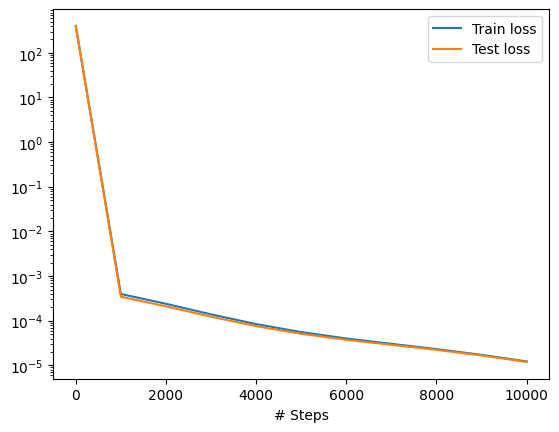

In [29]:
# Define the square domain (e.g., 2x2 square with side length L)

square = dde.geometry.Rectangle([-L, -L], [L, L])

# Define the circular hole at the center (radius R)
  # Radius of the hole
circle = dde.geometry.Disk([0, 0], R)

# Geometry and time domain
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the initial condition: C(x, y, 0) = 20
def initial_condition(x):
    return 20

# Define Dirichlet boundary conditions (e.g., C = 0 on the boundaries)
def boundary_condition(x, on_boundary):
    return on_boundary

# Create the initial and boundary conditions
ic = dde.icbc.IC(geomtime, lambda x: 20, lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_condition)

data = dde.data.TimePDE(
    geomtime,
    pde_C_L,[ic],
    num_domain=1000,
    num_boundary=150,
    num_initial=180,
    num_test=1000,
    )

# Network for C_L
layer_size = [3] + [64] * 3 + [1]  
activation = "tanh"
initializer = "Glorot uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)



# Define the model with the PDE, initial and boundary conditions
model= dde.Model(data, net_C_L)

# Compile the model with the custom loss function
model.compile("adam", lr=1e-3)

# Add the callback when training the model
losshistory, train_state = model.train(epochs=10000, callbacks=[constraint_callback])

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)